In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
sys.path.append(os.path.abspath('../..'))

from sep_bk_nn import SepBKNN
from sep_bk_nn.bk_functions import create_bk_dataset
from sep_bk_nn.bk_functions import bk_function_equilateral, bk_function_slow_collider_minus_eq

from scipy import integrate
import matplotlib.pyplot as plt


In [2]:
""" KZ todo:
    Done:
    1. add the extra argument to functions, for example slow-collider template has alpha
"""
import numpy as np
import torch

# kz note: seems VERY hard to learn due to the the divergence near 0
def bk_function_local(k1, k2, k3):
    return (k1**2 / (k2 * k3) + k2**2 / (k1 * k3) + k3**2 / (k1 * k2))/3

def bk_function_equilateral(k1, k2, k3):
    return (k1/k2 + k2/k1 + k1/k3 + k3/k1 + k2/k3 + k3/k2)\
         - (k1**2 / (k2 * k3) + k2**2 / (k1 * k3) + k3**2 / (k1 * k2)) - 2

def bk_function_test_1(k1, k2, k3):
    return k1**2 / (k2 * k3)

# 2307.01751: eq 5.15 minus the equilateral part. 
def bk_function_slow_collider_minus_eq(k1, k2, k3, alpha=0.1):
    return   (k1**2/k2/k3) / (1. + (alpha*k1**2/k2/k3)**2) / 3\
            +(k2**2/k1/k3) / (1. + (alpha*k2**2/k1/k3)**2) / 3\
            +(k3**2/k1/k2) / (1. + (alpha*k3**2/k1/k2)**2) / 3

def bk_function_slow_collider_full(k1, k2, k3, alpha=0.1):
    return  bk_function_slow_collider_minus_eq(k1, k2, k3, alpha) + bk_function_equilateral(k1,k2,k3)

# Dictionary containing function info: function object and default arguments
FUNCTION_MAP = {
    'bk_loc': {
        'func': bk_function_local,
        'default_args': {}
    },
    'bk_eq': {
        'func': bk_function_equilateral,
        'default_args': {}
    },
    'bk_test1': {
        'func': bk_function_test_1,
        'default_args': {}
    },
    'bk_sl_collider': {
        'func': bk_function_slow_collider_minus_eq,
        'default_args': {'alpha': 0.1}
    },
    'bk_sl_collider_full': {
        'func': bk_function_slow_collider_full,
        'default_args': {'alpha': 0.1}
    },
}

def get_function(func_name):
    """
    Returns the function and its default arguments
    """
    if func_name not in FUNCTION_MAP:
        raise ValueError(f"Unknown function: {func_name}")
    return FUNCTION_MAP[func_name]


def create_bk_dataset(grid_points, func_name, func_arg, kmin=0.01, kmax=1.0, n_points_k2=None, scale_invariant=True, k2_sample_version=0):
    func_info = get_function(func_name)
    func = func_info['func']
    func_args_input = func_info['default_args'].copy()
    if func_arg is not None:
            func_args_input.update(func_arg)
    # print('kz testing', func_args_input)
    if scale_invariant:
        ks_scale_invariant = generate_scale_invariant_k_points(n_points_k1=grid_points, kmin=kmin, kmax=kmax, n_points_k2=n_points_k2, k2_sample_version=k2_sample_version)
    else:
        raise NotImplementedError
    y = func(ks_scale_invariant[:, 0], ks_scale_invariant[:, 1], ks_scale_invariant[:, 2], **func_args_input)
    return torch.tensor(ks_scale_invariant, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).view(-1, 1)


def generate_scale_invariant_k_points(n_points_k1=300, kmin = 0.001, kmax=None, n_points_k2 = None, k2_sample_version=2):
    """
    Generates k points where:
    1. k3 = 1 (fixed due to scale invariance)
    2. k1 < k2 < k3=1 (ordered)
    3. k3=1 < k1 + k2 (triangle inequality)

    Note: k1 and k2 in this case is k1/k3 and k2/k3 since k3 is normalized to 1 for scale-invariant calculations

    KZ Note: I thought there is a one-liner numpy solution but could not find it

    """
    points = []
    
    if k2_sample_version=='full_uniform':
        if n_points_k2 is None:
            n_points_k2 = n_points_k1
        if kmax is None:
            kmax = 1.0
            
        ### START ver=0
        step_size = (kmax-kmin)/n_points_k1
        # Since k3=kmax, and k1 < k2 < kmax, we can start small and work up
        for k1 in np.linspace(kmin, kmax, n_points_k1):
            # avoid duplicated [1,1,1]
            if k1 == kmax:
                points.append((k1, k2, 1.0))
                continue
            # k2 must be greater than k1 but less than 1
            for k2 in np.arange(k1, kmax, step_size):
                if k2==1.:
                    print('kztest')
                # Check triangle inequality: 1 < k1 + k2
                if 1 <= k1 + k2:
                    points.append((k1, k2, 1.0)) # k3=1.0 in this function, kmax is for k1/k3 and k2/k3
        points = np.array(points)
        print('kz tesitng', points.shape)
        ### END ver=0
        
        ### START ver=1
        assert kmin>=0 #kmax<=1 # these are relativequantities
        k1,k2 = np.meshgrid(*[np.linspace(kmin, kmax, n_points_k1) for _ in range(2)])

        # kfilt = (np.abs(k2-k1)<=1)&(k2+k1>=1)&(k2>=k1)&(1>=k2)
        kfilt = (np.abs(k2-k1)<=1)&(k2+k1>=1)&(k2>=k1)&(kmax>=k2)

        points2 = np.asarray([k1[kfilt].ravel(),k2[kfilt].ravel(),np.ones_like(k1[kfilt]).ravel()]).T
        print('kz tesitng', points2.shape)
        return np.vstack((points, points2))
        ### END ver=1
    
    # fix the step size according to n_points_k1
    if k2_sample_version==0:
        if n_points_k2 is None:
            n_points_k2 = n_points_k1
        if kmax is None:
            kmax = 1.0

        step_size = (kmax-kmin)/n_points_k1
        # Since k3=kmax, and k1 < k2 < kmax, we can start small and work up
        for k1 in np.linspace(kmin, kmax, n_points_k1):
            # avoid duplicated [1,1,1]
            if k1 == kmax:
                points.append((k1, k2, 1.0))
                continue
            # k2 must be greater than k1 but less than 1
            for k2 in np.arange(k1, kmax, step_size):
                # Check triangle inequality: 1 <= k1 + k2
                if 1 <= k1 + k2:
                    points.append((k1, k2, 1.0)) # k3=1.0 in this function, kmax is for k1/k3 and k2/k3
        return np.array(points)

    if k2_sample_version==2:
        assert kmin>=0 #, kmax<=1 # these are relativequantities
        k1,k2 = np.meshgrid(*[np.linspace(kmin, kmax, n_points_k1) for _ in range(2)])

        # kfilt = (np.abs(k2-k1)<=1)&(k2+k1>=1)&(k2>=k1)&(1>=k2)
        kfilt = (np.abs(k2-k1)<=1)&(k2+k1>=1)&(k2>=k1)&(kmax>=k2)

        points = np.asarray([k1[kfilt].ravel(),k2[kfilt].ravel(),np.ones_like(k1[kfilt]).ravel()]).T
        
        return np.array(points)

k2 min 0.5102041
k2 min 0.5102041 where k1 is [0.48979592 0.5102041 ]
k shape (638, 3)


/tmp/ipykernel_1111954/4000125016.py:13: RuntimeWarning: divide by zero encountered in divide
  return (k1/k2 + k2/k1 + k1/k3 + k3/k1 + k2/k3 + k3/k2)\
/tmp/ipykernel_1111954/4000125016.py:14: RuntimeWarning: divide by zero encountered in divide
  - (k1**2 / (k2 * k3) + k2**2 / (k1 * k3) + k3**2 / (k1 * k2)) - 2
/tmp/ipykernel_1111954/4000125016.py:13: RuntimeWarning: invalid value encountered in subtract
  return (k1/k2 + k2/k1 + k1/k3 + k3/k1 + k2/k3 + k3/k2)\


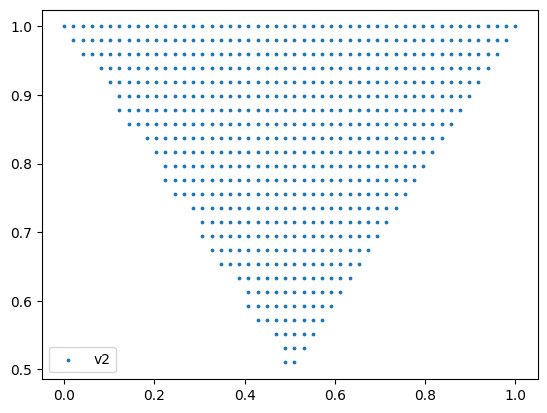

In [3]:
k_vals, bk = create_bk_dataset(grid_points=50, func_name='bk_eq', func_arg=None, kmin=0.0,\
                               kmax=1.0, n_points_k2=None, scale_invariant=True, k2_sample_version=2)
k_vals = k_vals.numpy()
bk = bk.numpy()
print('k2 min', k_vals[:,1].min())
print('k2 min', k_vals[:,1].min(), 'where k1 is', k_vals[:,0][np.where(k_vals[:,1]==k_vals[:,1].min())[0]])
print('k shape', k_vals.shape)
plt.scatter(k_vals[:,0], k_vals[:,1], s=3,label='v2')

plt.legend()

In [4]:
np.where(k_vals[:,1]==1)[0].shape

(50,)

kz tesitng (62500, 3)
kz tesitng (62612, 3)
k2 min 0.501002 where k1 is [0.501002 0.501002]


/tmp/ipykernel_1111954/4000125016.py:13: RuntimeWarning: divide by zero encountered in divide
  return (k1/k2 + k2/k1 + k1/k3 + k3/k1 + k2/k3 + k3/k2)\
/tmp/ipykernel_1111954/4000125016.py:14: RuntimeWarning: divide by zero encountered in divide
  - (k1**2 / (k2 * k3) + k2**2 / (k1 * k3) + k3**2 / (k1 * k2)) - 2
/tmp/ipykernel_1111954/4000125016.py:13: RuntimeWarning: invalid value encountered in subtract
  return (k1/k2 + k2/k1 + k1/k3 + k3/k1 + k2/k3 + k3/k2)\


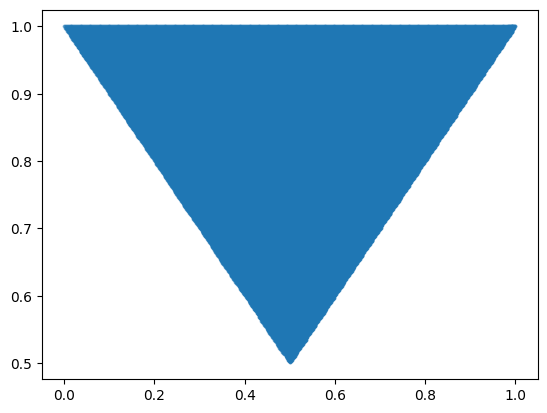

In [5]:
k_vals, bk = create_bk_dataset(grid_points=500, func_name='bk_eq', func_arg=None, kmin=0.0,\
                               kmax=1.0, n_points_k2=None, scale_invariant=True, k2_sample_version='full_uniform')
k_vals = k_vals.numpy()
bk = bk.numpy()
print('k2 min', k_vals[:,1].min(), 'where k1 is', k_vals[:,0][np.where(k_vals[:,1]==k_vals[:,1].min())[0]])

plt.scatter(k_vals[:,0], k_vals[:,1], s=3, alpha=0.5, label='v0')



k2 min 0.501002 where k1 is [0.501002]
k shape (62500, 3)
k2 min 0.501002
k2 min 0.501002 where k1 is [0.501002]
k shape (62612, 3)


/tmp/ipykernel_1111954/4000125016.py:13: RuntimeWarning: divide by zero encountered in divide
  return (k1/k2 + k2/k1 + k1/k3 + k3/k1 + k2/k3 + k3/k2)\
/tmp/ipykernel_1111954/4000125016.py:14: RuntimeWarning: divide by zero encountered in divide
  - (k1**2 / (k2 * k3) + k2**2 / (k1 * k3) + k3**2 / (k1 * k2)) - 2
/tmp/ipykernel_1111954/4000125016.py:13: RuntimeWarning: invalid value encountered in subtract
  return (k1/k2 + k2/k1 + k1/k3 + k3/k1 + k2/k3 + k3/k2)\


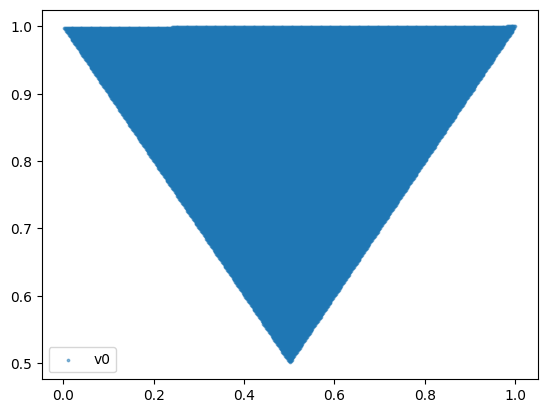

In [6]:
k_vals, bk = create_bk_dataset(grid_points=500, func_name='bk_eq', func_arg=None, kmin=0.0,\
                               kmax=1.0, n_points_k2=None, scale_invariant=True, k2_sample_version=0)
k_vals = k_vals.numpy()
bk = bk.numpy()
print('k2 min', k_vals[:,1].min(), 'where k1 is', k_vals[:,0][np.where(k_vals[:,1]==k_vals[:,1].min())[0]])
print('k shape', k_vals.shape)
plt.scatter(k_vals[:,0], k_vals[:,1], s=3, alpha=0.5, label='v0')


# k_vals, bk = create_bk_dataset(grid_points=50, func_name='bk_eq', func_arg=None, kmin=0.0,\
#                                kmax=1.05, n_points_k2=None, scale_invariant=True, k2_sample_version=0)
# k_vals = k_vals.numpy()
# bk = bk.numpy()
# k_vals[:,1]

# plt.scatter(k_vals[:,0], k_vals[:,1], s=3, alpha=0.5, label='more kmax')

k_vals, bk = create_bk_dataset(grid_points=500, func_name='bk_eq', func_arg=None, kmin=0.0,\
                               kmax=1.0, n_points_k2=None, scale_invariant=True, k2_sample_version=2)
k_vals = k_vals.numpy()
bk = bk.numpy()
print('k2 min', k_vals[:,1].min())
print('k2 min', k_vals[:,1].min(), 'where k1 is', k_vals[:,0][np.where(k_vals[:,1]==k_vals[:,1].min())[0]])
print('k shape', k_vals.shape)
# plt.scatter(k_vals[:,0], k_vals[:,1], s=3, alpha=0.5, label='v2')

plt.legend()

k2 min 0.5025126
k2 min 0.5025126 where k1 is [0.49748743 0.5025126 ]
k2 min 0.5024623
k2 min 0.5024623 where k1 is [0.5024623]


/tmp/ipykernel_1111954/4000125016.py:13: RuntimeWarning: divide by zero encountered in divide
  return (k1/k2 + k2/k1 + k1/k3 + k3/k1 + k2/k3 + k3/k2)\
/tmp/ipykernel_1111954/4000125016.py:14: RuntimeWarning: divide by zero encountered in divide
  - (k1**2 / (k2 * k3) + k2**2 / (k1 * k3) + k3**2 / (k1 * k2)) - 2
/tmp/ipykernel_1111954/4000125016.py:13: RuntimeWarning: invalid value encountered in subtract
  return (k1/k2 + k2/k1 + k1/k3 + k3/k1 + k2/k3 + k3/k2)\


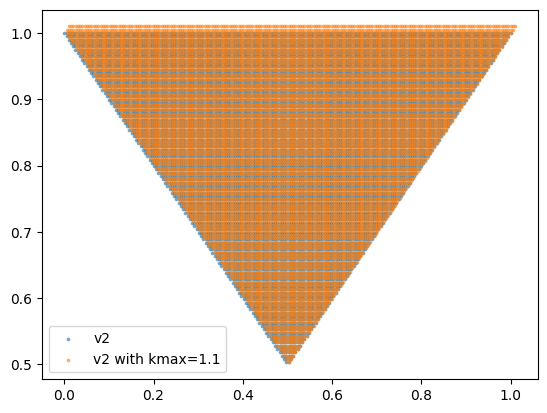

In [7]:
k_vals, bk = create_bk_dataset(grid_points=200, func_name='bk_eq', func_arg=None, kmin=0.0,\
                               kmax=1.0, n_points_k2=None, scale_invariant=True, k2_sample_version=2)
k_vals = k_vals.numpy()
bk = bk.numpy()
print('k2 min', k_vals[:,1].min())
print('k2 min', k_vals[:,1].min(), 'where k1 is', k_vals[:,0][np.where(k_vals[:,1]==k_vals[:,1].min())[0]])

plt.scatter(k_vals[:,0], k_vals[:,1], s=3, alpha=0.5, label='v2')

plt.legend()

k_vals, bk = create_bk_dataset(grid_points=200, func_name='bk_eq', func_arg=None, kmin=0.0,\
                               kmax=1.01, n_points_k2=None, scale_invariant=True, k2_sample_version=2)
k_vals = k_vals.numpy()
bk = bk.numpy()
print('k2 min', k_vals[:,1].min())
print('k2 min', k_vals[:,1].min(), 'where k1 is', k_vals[:,0][np.where(k_vals[:,1]==k_vals[:,1].min())[0]])

plt.scatter(k_vals[:,0], k_vals[:,1], s=3, alpha=0.5, label='v2 with kmax=1.1')

plt.legend()

(2500, 3)


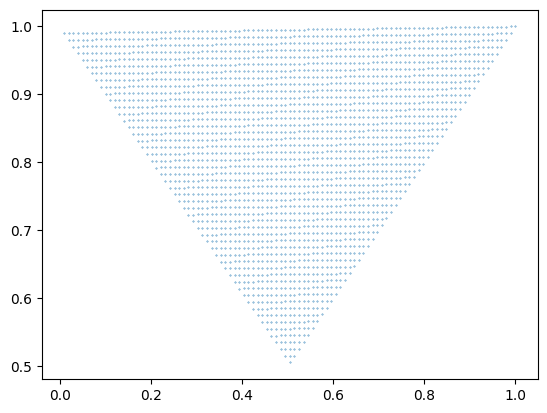

In [8]:
k_vals, bk = create_bk_dataset(grid_points=100, func_name='bk_eq', func_arg=None, kmin=0.0001,\
                               kmax=1.0, n_points_k2=None, scale_invariant=True, k2_sample_version=0)
k_vals = k_vals.numpy()
bk = bk.numpy()
# bk = bk*bk # TEST FOR INNER PRODUCT
print(k_vals.shape)

plt.scatter(k_vals[:,0], k_vals[:,1], s=0.1)

(625, 3)
(638, 3)


/tmp/ipykernel_1111954/4000125016.py:13: RuntimeWarning: divide by zero encountered in divide
  return (k1/k2 + k2/k1 + k1/k3 + k3/k1 + k2/k3 + k3/k2)\
/tmp/ipykernel_1111954/4000125016.py:14: RuntimeWarning: divide by zero encountered in divide
  - (k1**2 / (k2 * k3) + k2**2 / (k1 * k3) + k3**2 / (k1 * k2)) - 2
/tmp/ipykernel_1111954/4000125016.py:13: RuntimeWarning: invalid value encountered in subtract
  return (k1/k2 + k2/k1 + k1/k3 + k3/k1 + k2/k3 + k3/k2)\


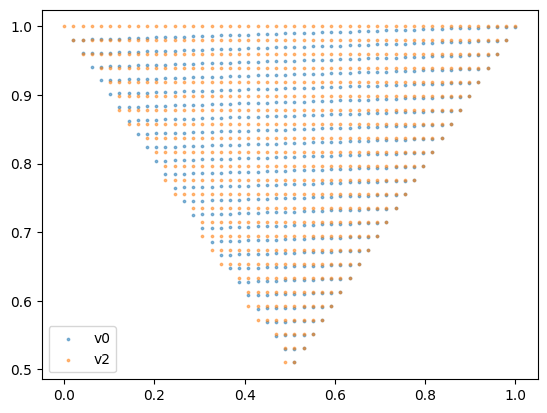

In [9]:
k_vals, bk = create_bk_dataset(grid_points=50, func_name='bk_eq', func_arg=None, kmin=0.0,\
                               kmax=1.0, n_points_k2=None, scale_invariant=True, k2_sample_version=0)
k_vals = k_vals.numpy()
bk = bk.numpy()
# bk = bk*bk # TEST FOR INNER PRODUCT
print(k_vals.shape)

plt.scatter(k_vals[:,0], k_vals[:,1], s=3, alpha=0.5, label='v0')

k_vals, bk = create_bk_dataset(grid_points=50, func_name='bk_eq', func_arg=None, kmin=0.0,\
                               kmax=1.0, n_points_k2=None, scale_invariant=True, k2_sample_version=2)
k_vals = k_vals.numpy()
bk = bk.numpy()
# bk = bk*bk # TEST FOR INNER PRODUCT
print(k_vals.shape)

plt.scatter(k_vals[:,0], k_vals[:,1], s=3, alpha=0.5, label='v2')
plt.legend()

/tmp/ipykernel_1111954/4000125016.py:13: RuntimeWarning: divide by zero encountered in divide
  return (k1/k2 + k2/k1 + k1/k3 + k3/k1 + k2/k3 + k3/k2)\
/tmp/ipykernel_1111954/4000125016.py:14: RuntimeWarning: divide by zero encountered in divide
  - (k1**2 / (k2 * k3) + k2**2 / (k1 * k3) + k3**2 / (k1 * k2)) - 2
/tmp/ipykernel_1111954/4000125016.py:13: RuntimeWarning: invalid value encountered in subtract
  return (k1/k2 + k2/k1 + k1/k3 + k3/k1 + k2/k3 + k3/k2)\


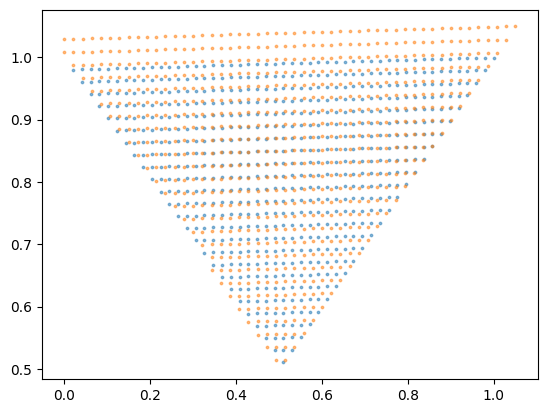

In [10]:
k_vals, bk = create_bk_dataset(grid_points=50, func_name='bk_eq', func_arg=None, kmin=0.0,\
                               kmax=1.0, n_points_k2=None, scale_invariant=True, k2_sample_version=0)
k_vals = k_vals.numpy()
bk = bk.numpy()
k_vals[:,1]

plt.scatter(k_vals[:,0], k_vals[:,1], s=3, alpha=0.5, label='v0')


k_vals, bk = create_bk_dataset(grid_points=50, func_name='bk_eq', func_arg=None, kmin=0.0,\
                               kmax=1.05, n_points_k2=None, scale_invariant=True, k2_sample_version=0)
k_vals = k_vals.numpy()
bk = bk.numpy()
k_vals[:,1]

plt.scatter(k_vals[:,0], k_vals[:,1], s=3, alpha=0.5, label='more kmax')


In [28]:
def Delta_fNL_scale_w_interp_TEST(k_vals, bk_result_1, bk_result_2, kmin, scale_invariant=True, DEBUG=False):
    """
    KZ note: I try to make the integration as defensive as possible for nans. But the interpolater can still give nan. 
            see:https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.LinearNDInterpolator.html#scipy.interpolate.LinearNDInterpolator
            note the irregular of shapes of the interpolation boundaries
            For now I'll just force these points to 0.
            
            In the future maybe consider extrapolation with interpn, but I don't fill safe with that.
            
    Compute integral using interpolation of grid data
    from bk_result_1 and bk_result_2. This would give:
    <bk_result_1-bk_result_2 | bk_result_1 - bk_result_2> / <bk_result_2 | bk_result_2>
    """
    if not scale_invariant:
        raise NotImplementedError

    k1_grid = k_vals[:,0]
    k2_grid = k_vals[:,1]
    k3_grid = k_vals[:,2]
    
    assert np.all(k3_grid == 1), "k3 is not all 1. ?"
    assert bk_result_1.shape[0] == bk_result_2.shape[0], "the two sets of Bk should be evaluated at the same ks"

    # Create interpolation function
    interp_func_1 = interpolate.CloughTocher2DInterpolator(
        list(zip(k1_grid, k2_grid)), bk_result_1
    )

    interp_func_2 = interpolate.CloughTocher2DInterpolator(
        list(zip(k1_grid, k2_grid)), bk_result_2
    )
    
    def integrand_diff(x, y):
        # Square the interpolated function value
        return (interp_func_1(x, y) - interp_func_2(x, y))**2

    def integrand_2(x, y):
        # Square the interpolated function value
        result = (interp_func_2(x, y))**2
        if DEBUG:
            if np.isnan(result):
                print(f"NaN encountered in integrand at x={x:.6f}, y={y:.6f}")
        return result
    
    def integrand_diff_safe(x, y):
        if y >= x and y+x>1. and y <= 1.0 and x > kmin and x < 1.0:  # Only evaluate within the valid region
            result = integrand_diff(x, y)
        else:
            result = 0.0  # Return 0 for points outside our region of interest
        if DEBUG:
            if np.isnan(result):
                print(f"NaN encountered in integrand at x={x:.6f}, y={y:.6f}")
        # KZ note: this is not ideal
        if np.isnan(result):
            result = 0.
        return result
    
    def integrand_2_safe(x, y):
        if y >= x and y+x>1. and y <= 1.0 and x > kmin and x < 1.0:  # Only evaluate within the valid region
            result = integrand_2(x, y)
        else:
            result = 0.0  # Return 0 for points outside our region of interest
        if DEBUG:
            if np.isnan(result):
                print(f"NaN encountered in integrand at x={x:.6f}, y={y:.6f}")
        # KZ note: this is not ideal
        if np.isnan(result):
            result = 0.
        return result
    
    # Inner product of 1 and 2
    IP_1_2, error_1 = integrate.dblquad(
        integrand_diff_safe,
        kmin+1e-6, 
        1.,  # x limits
        lambda x: 0., # note the for stablitiy the limit on y is handeled in integra_XX_safe
        lambda x: 1.
    )

    IP_1_1, error_2 = integrate.dblquad(
        integrand_2_safe,
        kmin+1e-6, 
        1.,  # x limits
        lambda x: 0., # note the for stablitiy the limit on y is handeled in integra_XX_safe
        lambda x: 1.
    )
    
    # KZ TESTING START
    if DEBUG:
        test_x = np.linspace(kmin, 1.0, 100)
        test_y = np.linspace(0, 1.0, 100)
        for x in test_x:
            for y in test_y:
                if y >= 1.0-x and y <= 1.0 and y>x:  # Only test points in your integration region
                    val = integrand_2(x, y)
                    if np.isnan(val):
                        print(f"Found NaN at x={x}, y={y}")
    # KZ TESTING END
    print(IP_1_2, IP_1_1)
    Delta_fNL = IP_1_2 / IP_1_1
    print('true <B|B> is', IP_1_1)
    print('The bias estimation of fNL is Delta_fNL = ', Delta_fNL)

    return Delta_fNL


In [29]:
k_vals, bk = create_bk_dataset(grid_points=50, func_name='bk_sl_collider', func_arg=None, kmin=0.0,\
                               kmax=1.0, n_points_k2=None, scale_invariant=True, k2_sample_version=2)
k_vals = k_vals.numpy()
bk = bk.numpy()
print(k_vals.shape)

(638, 3)


/tmp/ipykernel_1111954/4000125016.py:22: RuntimeWarning: divide by zero encountered in divide
  +(k2**2/k1/k3) / (1. + (alpha*k2**2/k1/k3)**2) / 3\
/tmp/ipykernel_1111954/4000125016.py:22: RuntimeWarning: invalid value encountered in divide
  +(k2**2/k1/k3) / (1. + (alpha*k2**2/k1/k3)**2) / 3\
/tmp/ipykernel_1111954/4000125016.py:23: RuntimeWarning: divide by zero encountered in divide
  +(k3**2/k1/k2) / (1. + (alpha*k3**2/k1/k2)**2) / 3
/tmp/ipykernel_1111954/4000125016.py:23: RuntimeWarning: invalid value encountered in divide
  +(k3**2/k1/k2) / (1. + (alpha*k3**2/k1/k2)**2) / 3


In [30]:
from scipy import interpolate
from scipy import integrate

In [32]:
""" KZ note:
    for bk_eq, Mathematica gives: 0.1098022005. Pretty similar to this. and seems kmin = 0.01 is fine in this case. 
    A equilateral should peak at <1,1,1> anyways
"""

Delta_fNL_scale_w_interp_TEST(k_vals, bk, bk, kmin=k_vals.min(), DEBUG=False)


0.0 0.0


ZeroDivisionError: float division by zero

In [ ]:
# other tests: add 0.1 to every point at bk gives bias = 0.022?? is this too small? But if not than the training seems to be completely ok
# maybe not impossible because mse should be of this order, and the integration over S^2 should be similar

Delta_fNL_scale_w_interp_TEST(k_vals, bk+0.1, bk, kmin=k_vals.min(), DEBUG=False)

# below is test

In [ ]:
def plot_3d_data(xy_vals, bk, method='scatter', title='3D Plot'):
    """
    Plot 3D data with color mapping
    
    Args:
        k_vals: array of shape (N, 2) containing x and y coordinates
        bk: array of shape (N,) containing z values
        method: 'scatter' or 'surface'
        title: plot title
    """
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection='3d')
    
    # Set viewing angle
    ax.azim = -75
    ax.dist = 10
    ax.elev = 30
    
    x = xy_vals[:, 0]
    y = xy_vals[:, 1]
    z = bk.flatten()
    
    if method == 'scatter':
        # Create scatter plot with color mapping
        scatter = ax.scatter3D(x, y, z, 
                             c=z,  # Color by z value
                             cmap='viridis',  # Choose colormap
                             s=30,  # Marker size
                             alpha=0.6)  # Transparency
        
        # Add colorbar
        fig.colorbar(scatter, ax=ax, label='Z Value')
        
    elif method == 'surface':
        # Create triangulation surface plot
        surf = ax.plot_trisurf(x, y, z,
                             cmap='viridis',
                             alpha=0.8)
        
        # Add colorbar
        fig.colorbar(surf, ax=ax, label='Z Value')
    
    # Labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    
    # Set axis limits if needed
    # ax.set_xlim([x.min(), x.max()])
    # ax.set_ylim([y.min(), y.max()])
    # ax.set_zlim([z.min(), z.max()])
    
    plt.show()

In [ ]:

# Generate sample data
n_points = k_vals.shape[0]
x = k_vals[:,0]
y = k_vals[:,1]
z = bk.flatten()

xy_vals = np.column_stack((x, y))

# Create both types of plots
plot_3d_data(xy_vals, z, method='scatter', title='3D Scatter Plot with Color Mapping')


In [ ]:
k1_grid = k_vals[:,0]
k2_grid = k_vals[:,1]
kmin = k_vals.min()

# Check interpolation domain coverage
print("k1_grid range:", np.min(k1_grid), np.max(k1_grid))
print("k2_grid range:", np.min(k2_grid), np.max(k2_grid))

# Plot interpolation points and integration domain
plt.scatter(k1_grid, k2_grid, c='blue', alpha=0.5, label='Interpolation points')

# Plot integration domain
x = np.linspace(kmin, 1, 100)
y_min = np.maximum(x, 1-x)
y_max = np.ones_like(x)
# print(y_min, y_max)
plt.fill_between(x, y_min, y_max, alpha=0.3, color='red', label='Integration domain')

plt.legend()
plt.xlabel('k1')
plt.ylabel('k2')
plt.title('Interpolation Points vs Integration Domain')
plt.show()

In [ ]:


interp_func_2 = interpolate.CloughTocher2DInterpolator(
        list(zip(k1_grid, k2_grid)), bk)

In [ ]:
# KZ note: this still is nan, has to do with interpolator

testx=0.361336
testy=0.638669
print(testx+testy)
interp_func_2(testx, testy)

In [ ]:
# Plot interpolation points and integration domain
plt.scatter(k1_grid, k2_grid, c='blue', alpha=0.5, label='Interpolation points')

plt.scatter(testx, testy, c='red')